In [1]:
import pandas as pd
import numpy as np

df_boston = pd.read_csv('./data/boston_2015.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
print(f'Total number of rows: {len(df_boston)}')

Total number of rows: 1122558


In [2]:
df_boston.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer


In [3]:
df_boston['user_type'].unique()

<StringArray>
['Subscriber', 'Customer']
Length: 2, dtype: string

# Preprocessing
### Set data type of 'end_station_id'

In [4]:
df_boston['end_station_id'].unique()

<StringArray>
[ '96',  '95',  '68',  '88',  '76', '118',  '75',  '67',  '36',  '23',
 ...
 '169', '174', '175', '159', '171', '178', '176', '179', '180', '177']
Length: 157, dtype: string

In [5]:
# Value '\\N' seems to be anomaly -> occurs only once, so drop!
num_occurences = len(df_boston.loc[df_boston["end_station_id"] == "\\N"])
print(f'Number of "\\\\N" occurences in end_station_id column: {num_occurences}')
df_boston.drop(index=df_boston.loc[df_boston["end_station_id"] == "\\N"].index, inplace=True, axis=1)

# now set column to dtype np.int64
df_boston = df_boston.astype({'end_station_id': np.int64})
df_boston.info()

Number of "\\N" occurences in end_station_id column: 1
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122557 entries, 0 to 1122557
Data columns (total 8 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   start_time          1122557 non-null  object
 1   end_time            1122557 non-null  object
 2   start_station_id    1122557 non-null  int64 
 3   end_station_id      1122557 non-null  int64 
 4   start_station_name  1122557 non-null  string
 5   end_station_name    1122557 non-null  string
 6   bike_id             1122557 non-null  int64 
 7   user_type           1122557 non-null  string
dtypes: int64(3), object(2), string(3)
memory usage: 77.1+ MB


### Set data type of time columns

In [6]:
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')
df_boston['end_time'] = pd.to_datetime(df_boston['end_time'], format='%Y-%m-%d %X')
df_boston.dtypes

start_time            datetime64[ns]
end_time              datetime64[ns]
start_station_id               int64
end_station_id                 int64
start_station_name            string
end_station_name              string
bike_id                        int64
user_type                     string
dtype: object

#### Check if station id and names are unique tuples

In [7]:
# len(df_boston['start_station_name'].unique())
is_unique = True
i = 0
all_station_ids = df_boston['start_station_id'].unique()

while i < len(all_station_ids) & is_unique:
    is_unique = len(df_boston.loc[df_boston['start_station_id'] == i]['start_station_name'].unique()) == 1
    i += 1

print("Station IDs and names are unique", is_unique)


Station IDs and names are unique True


In [8]:
# Check if station id and name always match
unique_start_tuples = np.unique(df_boston[['start_station_id', 'start_station_name']].values.astype('str'), axis=0)
unique_start_tuples

array([['1', '18 Dorrance Warehouse'],
       ['10', 'B.U. Central - 725 Comm. Ave.'],
       ['100', 'Davis Square'],
       ['102', 'Powder House Circle - Nathan Tufts Park'],
       ['103', 'JFK Crossing at Harvard St. / Thorndike St.'],
       ['104',
        'Harvard University Radcliffe Quadrangle at Shepard St / Garden St'],
       ['105', 'Lower Cambridgeport at Magazine St/Riverside Rd'],
       ['106', 'Mt Pleasant Ave / Dudley Town Common'],
       ['107', 'Ames St at Main St'],
       ['108',
        'Harvard University / SEAS Cruft-Pierce Halls at 29 Oxford St'],
       ['109', 'TD Garden - Causeway at Portal Park #1'],
       ['11', 'Longwood Ave / Binney St'],
       ['110', 'Harvard University Gund Hall at Quincy St / Kirkland S'],
       ['111', 'Packard Ave / Powderhouse Blvd'],
       ['112', 'Somerville Hospital at Highland Ave / Crocker St'],
       ['113', 'Andrew Station - Dorchester Ave at Humboldt Pl'],
       ['114', 'Teele Square at 239 Holland St'],
       [

In [9]:
#TODO: check for entire duplicates (also end stations)
unique_start_tuples[:,0:1]
u, c = np.unique(unique_start_tuples[:,0:1], return_counts=True)
dup = u[c > 1]
dup 

array([], dtype='<U70')

# Feature Engineering
#### Calculate trip_length 

In [10]:
df_boston['trip_length'] = (df_boston['end_time'] - df_boston['start_time'])
df_boston['trip_length'] = df_boston['trip_length'] / np.timedelta64(1, 's')
df_boston.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer,735.0


# First Data Exploration
### Understanding the revenue modell

![caption](data/thehubway_revenue_modell_2015.png)

In [11]:
# Pricing info pulled from: https://web.archive.org/web/20150206035343/http://www.thehubway.com:80/pricing
# INFO: bluebikes was previously called 'thehubway', see https://en.wikipedia.org/wiki/Bluebikes
# ASSUMTION: The revenue modell did not change over the year 2015. This was checked through all entries of the wayback-machine, which occured in 7 day intervalls. We can be pretty certain of this. 


# Get # of subscribers and customers
print(df_boston.groupby('user_type').size())
# TODO: Include this in revenue modell

# Thoughts on the revenue modell: We don't see individual user-ids for each ride. This means that we can only infer the "revenue" generated by each trip through the respective user_type.
# E.g. -> if we have 10 subscribers for a given timeframe, who undertake 100 trips, each trip would generate 1/10 of the users membership fee in the given timeframe
# Membership numbers for 2015: https://web.archive.org/web/20160208155519/http://www.thehubway.com/mediakit -> anual members: 13.248, Causal Passes: 102.445 (24 & 72 Hours) with a total of 1,1319,310 Trips (???)

no_trips_from_dataset_2015 = 11319310
no_trips_from_website_2015 = len(df_boston)
print(f'We only have {no_trips_from_website_2015/no_trips_from_dataset_2015} of the data!')

# Big Open Question: How should we deal with the missing data? (we only have 1/10 of the trip data apparently) ? -> https://s3.amazonaws.com/hubway-data/index.html this contains the raw data, it appears that there are a lot more than 112k rides..
# Open Question: How should we include the membership fees and casual passes costs in the revenue modell?


# get proprtion all the rides who might incur overtime fees (trip_length >30 min) to understand if this usage pattern is relevant for the revenue model
proportion_overtime_rides = len(df_boston[df_boston['trip_length'] >= (30*60)]) / len(df_boston) 
print(proportion_overtime_rides)

# Conclusion: Around 7% of rides were overtime -> we should include this in the revenue modell
# TODO: Engineer the following features for the revenue modell: revenue_through_overtime (calculated on the basis of trip_duration)


user_type
Customer      370585
Subscriber    751972
dtype: int64
We only have 0.09917185764856692 of the data!
0.06948154971195226


### merging of boston station dataset and the df_boston data

In [12]:
#boston blue bikes stations data
df_stations_data = pd.read_csv('./data/current_bluebikes_stations.csv', header=1)
df_january = pd.read_csv('./data/201501-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_sep = pd.read_csv('./data/201509-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_july = pd.read_csv('./data/201507-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_oct = pd.read_csv('./data/201510-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
df_dec = pd.read_csv('./data/201512-hubway-tripdata.csv', usecols=['start station id', 'start station latitude', 'start station longitude', 'end station id', 'end station id', 'end station latitude', 'end station longitude'])
unique_stations_external=np.unique(np.concatenate((df_january[['start station id', 'start station latitude', 'start station longitude']].values, df_january[['end station id', 'end station latitude', 'end station longitude']].values,df_july[['start station id', 'start station latitude', 'start station longitude']].values, df_july[['end station id', 'end station latitude', 'end station longitude']].values, df_sep[['start station id', 'start station latitude', 'start station longitude']].values, df_sep[['end station id', 'end station latitude', 'end station longitude']].values, df_oct[['start station id', 'start station latitude', 'start station longitude']].values, df_oct[['end station id', 'end station latitude', 'end station longitude']].values, df_dec[['start station id', 'start station latitude', 'start station longitude']].values, df_dec[['end station id', 'end station latitude', 'end station longitude']].values)), axis=0)

In [13]:
unique_stations_original=np.unique(np.concatenate((df_boston['start_station_name'].values, df_boston['end_station_name'].values)))
print(f'# stations from original data: {len(unique_stations_original)} | # stations from external data: {len(unique_stations_external)}')
df_unique_stations = pd.DataFrame(unique_stations_external, columns=['station_id', 'station_latitude', 'station_longitude'])

# stations from original data: 156 | # stations from external data: 156


In [14]:
df_unique_stations.columns = ['start_station_id', 'start_station_latitude', 'start_station_longitude']
df_boston = df_boston.merge(df_unique_stations, how='left', on='start_station_id')
df_unique_stations.columns = ['end_station_id', 'end_station_latitude', 'end_station_longitude']
df_boston = df_boston.merge(df_unique_stations, how='left', on='end_station_id')
df_boston.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1122557 entries, 0 to 1122556
Data columns (total 13 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   start_time               1122557 non-null  datetime64[ns]
 1   end_time                 1122557 non-null  datetime64[ns]
 2   start_station_id         1122557 non-null  int64         
 3   end_station_id           1122557 non-null  int64         
 4   start_station_name       1122557 non-null  string        
 5   end_station_name         1122557 non-null  string        
 6   bike_id                  1122557 non-null  int64         
 7   user_type                1122557 non-null  string        
 8   trip_length              1122557 non-null  float64       
 9   start_station_latitude   1122557 non-null  float64       
 10  start_station_longitude  1122557 non-null  float64       
 11  end_station_latitude     1122557 non-null  float64       
 12  

In [15]:
df_boston.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0,42.387995,-71.119084,42.373379,-71.111075
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0,42.361962,-71.092053,42.372969,-71.094445
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0,42.366277,-71.091690,42.365070,-71.103100
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0,42.387995,-71.119084,42.373379,-71.111075
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer,735.0,42.356954,-71.113687,42.374035,-71.101427


In [16]:
unique_stations_original=np.unique(np.concatenate((df_boston['start_station_name'].values, df_boston['end_station_name'].values)))
unique_stations_external = df_stations_data['Name'].values

In [17]:
print(f"#stations in stations dataset: {len(df_stations_data.loc[df_stations_data['Deployment Year'] < 2015.0])}")
print(f"#stations in original dataset: {len(unique_stations_original)}")

#stations in stations dataset: 130
#stations in original dataset: 156


In [18]:
stations_no_match = list(filter(lambda x: not(np.any(unique_stations_external == x)), unique_stations_original))
len(stations_no_match)

stations_no_match


['18 Dorrance Warehouse',
 'Agganis Arena - 925 Comm Ave.',
 'Allston Green District - Commonwealth Ave & Griggs St',
 'Andrew Station - Dorchester Ave at Humboldt Pl',
 'Aquarium Station - 200 Atlantic Ave.',
 'BIDMC - Brookline at Burlington St',
 'Back Bay / South End Station',
 'Beacon St / Mass Ave',
 'Beacon St at Washington / Kirkland',
 'Boston Convention & Exhibition Center',
 'Boston Medical Center -  East Concord at Harrison Ave',
 'Boston Public Library - 700 Boylston St.',
 'Boylston / Mass Ave',
 'Boylston St / Berkeley St',
 'Boylston St / Washington St',
 'Boylston St. at Arlington St.',
 'Boylston at Fairfield',
 'Brigham Cir / Huntington Ave',
 'Brighton Center',
 'Brookline Village - Pearl Street @ MBTA',
 'Buswell St. at Park Dr.',
 'Cambridge St. at Joy St.',
 'Charles Circle - Charles St. at Cambridge St.',
 'Charles St at Beacon St',
 'Charlestown - Main St at Austin St',
 'Charlestown - Warren St at Chelsea St',
 'Chinatown Gate Plaza - Surface Rd. at Beach St.'

In [19]:
stations_match = list(filter(lambda x: np.any(unique_stations_external == x), unique_stations_original))
stations_match

['359 Broadway - Broadway at Fayette Street',
 'Alewife Station at Russell Field',
 'Ames St at Main St',
 'B.U. Central - 725 Comm. Ave.',
 'Binney St / Sixth St',
 'Bunker Hill Community College',
 'Cambridge Main Library at Broadway / Trowbridge St',
 'Cambridge St - at Columbia St / Webster Ave',
 'CambridgeSide Galleria - CambridgeSide PL at Land Blvd',
 'Central Sq Post Office / Cambridge City Hall at Mass Ave / Pleasant St',
 'Central Square at Mass Ave / Essex St',
 'Conway Park - Somerville Avenue',
 'Dana Park',
 'Danehy Park',
 'Davis Square',
 'EF - North Point Park',
 'Fan Pier',
 'Harvard Kennedy School at Bennett St / Eliot St',
 'Harvard Law School at Mass Ave / Jarvis St',
 'Harvard Square at Brattle St / Eliot St',
 'Harvard Square at Mass Ave/ Dunster',
 'Harvard University / SEAS Cruft-Pierce Halls at 29 Oxford St',
 'Harvard University Housing - 115 Putnam Ave at Peabody Terrace',
 'Harvard University Radcliffe Quadrangle at Shepard St / Garden St',
 'Harvard Unive

# Plot start & end stations

In [20]:
len(df_boston)
df_boston.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0,42.387995,-71.119084,42.373379,-71.111075
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0,42.361962,-71.092053,42.372969,-71.094445
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0,42.366277,-71.091690,42.365070,-71.103100
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0,42.387995,-71.119084,42.373379,-71.111075
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer,735.0,42.356954,-71.113687,42.374035,-71.101427


In [21]:
df_start = df_boston.groupby(['start_station_id','start_station_latitude', 'start_station_longitude']).size().reset_index(name='counts_start')

In [22]:
df_end = df_boston.groupby(['end_station_id','end_station_latitude', 'end_station_longitude']).size().reset_index(name='counts_end')

In [23]:
df_start = df_start.sort_values('start_station_id')
df_end = df_end.sort_values('end_station_id')

df_ratio = df_start.copy()
df_ratio['count_end'] = df_end['counts_end']
df_ratio["ratio"] = df_start['counts_start']/df_end['counts_end']


df_ratio.sort_values('ratio').describe()


,start_station_id,start_station_latitude,start_station_longitude,counts_start,count_end,ratio
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,85.314103,42.355539,-71.089556,7195.878205,7195.878205,1.018733
std,49.862754,0.021187,0.028647,5680.263408,5803.203988,0.120328
min,1.000000,42.303469,-71.160411,46.000000,39.000000,0.363636
25%,43.750000,42.343900,-71.113428,2832.500000,2611.000000,0.968435
50%,84.500000,42.354157,-71.090935,6300.500000,6254.500000,1.005770
75%,124.250000,42.369364,-71.065351,10356.500000,10565.500000,1.053639
max,180.000000,42.404490,-71.028664,30798.000000,31284.000000,1.625000


In [24]:
df_station_share = df_start.copy()
df_station_share['total_rides'] = df_start['counts_start'] + df_end['counts_end']
yearly_total_rides = sum(df_station_share['total_rides'])
df_station_share['share'] = (df_station_share['total_rides'] / yearly_total_rides)*100
df_station_share.sort_values('share', ascending=False).head(5)

,start_station_id,start_station_latitude,start_station_longitude,counts_start,total_rides,share
19,22,42.352175,-71.055547,30798,62082,2.765205
61,67,42.358100,-71.093198,29597,59502,2.650289
68,74,42.373268,-71.118579,22679,46269,2.060875
62,68,42.365070,-71.103100,21444,42330,1.885428
101,109,42.365942,-71.060515,18678,39202,1.746103


In [26]:
import seaborn as sns

<AxesSubplot: xlabel='start_station_id', ylabel='share'>

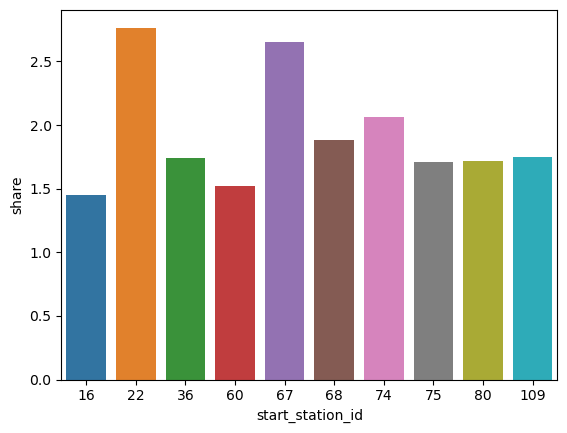

In [27]:
sns.barplot(df_station_share.loc[df_station_share['counts_start'] > 15000 ], x = "start_station_id", y = "share" )

In [ ]:
import plotly.express as px

In [ ]:

color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df_start, 
                        lat="start_station_latitude", 
                        lon="start_station_longitude", 
                        color='counts_start',
                        color_continuous_scale=color_scale,
                        size='counts_start',
                        zoom=8, 
                        height=800,
                        width=800)


fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [ ]:
color_scale = [(0, 'orange'), (1,'red')]

fig = px.scatter_mapbox(df_end, 
                        lat="end_station_latitude", 
                        lon="end_station_longitude", 
                        color='counts_end',
                        color_continuous_scale=color_scale,
                        size='counts_end',
                        zoom=8, 
                        height=800,
                        width=800)


fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [172]:
#number of trips between a start and end station

df_trips = df_boston.groupby(['start_station_id','end_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude']).size().reset_index(name='count_trips')

df_trips = df_trips.sort_values('count_trips', ascending = False)

df_trips.index = range(0, len(df_trips))

df_trips.head(10)

,start_station_id,end_station_id,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,count_trips
0,118,100,42.397828,-71.130516,42.396969,-71.123024,3020
1,100,118,42.396969,-71.123024,42.397828,-71.130516,2755
2,114,100,42.402763,-71.126908,42.396969,-71.123024,2047
3,67,53,42.358100,-71.093198,42.350851,-71.089886,2026
4,40,22,42.363871,-71.050877,42.352175,-71.055547,1982
5,67,68,42.358100,-71.093198,42.365070,-71.103100,1845
6,53,67,42.350851,-71.089886,42.358100,-71.093198,1783
7,22,40,42.352175,-71.055547,42.363871,-71.050877,1741
8,68,67,42.365070,-71.103100,42.358100,-71.093198,1610
9,20,22,42.359770,-71.051601,42.352175,-71.055547,1531


In [174]:
#mapping the top trips by including information about start and end station

import folium

avg_lat = df_trips['start_station_latitude'].mean()
avg_long = df_trips['start_station_longitude'].mean()

m = folium.Map(location=[avg_lat, avg_long], zoom_start=15)

points = []

df_top_trips = df_trips.head(10)

for i in range(0,len(df_top_trips)):
    points.append([df_top_trips.iloc[i]['start_station_latitude'],df_top_trips.iloc[i]['start_station_longitude']])
    points.append([df_top_trips.iloc[i]['end_station_latitude'],df_top_trips.iloc[i]['end_station_longitude']])
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)
    folium.Marker([df_top_trips.iloc[i]['start_station_latitude'],df_top_trips.iloc[i]['start_station_longitude']],popup=(df_top_trips.iloc[i]['start_station_id'], df_top_trips.iloc[i]['count_trips' ]), icon = folium.Icon(color='green',prefix='fa', icon='bicycle')).add_to(m)
    folium.Marker([df_top_trips.iloc[i]['end_station_latitude'],df_top_trips.iloc[i]['end_station_longitude']],popup=(df_top_trips.iloc[i]['end_station_id'], df_top_trips.iloc[i]['count_trips' ]), icon = folium.Icon(color='red',prefix='fa', icon='bicycle')).add_to(m)
    points = [] #if points is not reseted then each station will be connected with every other station in array

m 

In [223]:
#in the above map there are multiple lines on top of each other which is not optimal to show routes
#therefore we cumulate the total number of trips between two stations ignoring the information about the start/end point

df_total_trips = df_top_trips.copy()

for j in range(0, len(df_total_trips)):
    if j < len(df_total_trips):
        for i in range (0, len(df_total_trips)):
            if i < len(df_total_trips):
                if df_total_trips.at[j,'start_station_id'] == df_total_trips.at[i, 'end_station_id'] and df_total_trips.at[i,'start_station_id'] == df_total_trips.at[j, 'end_station_id']:
                    df_total_trips.at[j, 'count_trips'] = df_total_trips.at[i, 'count_trips'] + df_total_trips.at[j, 'count_trips']
                    df_total_trips = df_total_trips.drop(i)
                df_total_trips.index = range(0, len(df_total_trips))


df_total_trips
            
            

,start_station_id,end_station_id,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,count_trips
0,118,100,42.397828,-71.130516,42.396969,-71.123024,5775
1,114,100,42.402763,-71.126908,42.396969,-71.123024,2047
2,67,53,42.358100,-71.093198,42.350851,-71.089886,3809
3,40,22,42.363871,-71.050877,42.352175,-71.055547,3723
4,67,68,42.358100,-71.093198,42.365070,-71.103100,3455
5,20,22,42.359770,-71.051601,42.352175,-71.055547,1531


In [225]:

avg_lat = df_trips['start_station_latitude'].mean()
avg_long = df_trips['start_station_longitude'].mean()

m = folium.Map(location=[avg_lat, avg_long], zoom_start=15)

points = []


for i in range(0,len(df_total_trips)):
    points.append([df_total_trips.iloc[i]['start_station_latitude'],df_total_trips.iloc[i]['start_station_longitude']])
    points.append([df_total_trips.iloc[i]['end_station_latitude'],df_total_trips.iloc[i]['end_station_longitude']])
    folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)
    folium.Marker([df_total_trips.iloc[i]['start_station_latitude'],df_total_trips.iloc[i]['start_station_longitude']],popup=(df_total_trips.iloc[i]['start_station_id'], df_total_trips.iloc[i]['count_trips' ]), icon = folium.Icon(color='green',prefix='fa', icon='bicycle')).add_to(m)
    folium.Marker([df_total_trips.iloc[i]['end_station_latitude'],df_total_trips.iloc[i]['end_station_longitude']],popup=(df_total_trips.iloc[i]['end_station_id'], df_total_trips.iloc[i]['count_trips' ]), icon = folium.Icon(color='red',prefix='fa', icon='bicycle')).add_to(m)
    points = [] #if points is not reseted then each station will be connected with every other station in array

m 